In [13]:
import os
from pathlib import Path
import logging
import itertools

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer

from sentiment_analysis.config import SentimentAnalysisConfig
from sentiment_analysis.data_access import DataClass
from sentiment_analysis.utils.constants import (
    TEXT,
    TARGET,
    ORIGINAL_TEXT,
    SPLIT,
    DEVELOP,
    TEST
)

sns.set_style("darkgrid")
sns.set_color_codes("muted")
matplotlib.rcParams['font.family'] = "serif"
PARENT_PATH = Path(os.getcwd()).parent.absolute()
FORMAT = "%(asctime)s - %(name)s - %(levelname)s - %(message)s"
logging.basicConfig(format=FORMAT, level=logging.INFO)

In [2]:
config = SentimentAnalysisConfig()
config.CURRENT_PATH = PARENT_PATH

data = DataClass(config)
df = data.build()
df.head(10)

,review,sentiment,Split
0,how can a director that makes such great films...,neg,train
1,This is one of the worst film adaptations of a...,neg,train
2,This is an art film that was either made in 19...,neg,train
3,"For two of the funniest comedians, the movie w...",neg,train
4,Doris Day never lets a bad script get her down...,neg,train
5,Unwatchable. You can't even make it past the f...,neg,train
6,"Quite average even by Monogram standards, this...",neg,train
7,This is not a good movie. Too preachy in parts...,neg,train
8,I am really shocked that a great director like...,neg,train
9,This is one of the weakest soft porn film arou...,neg,train


Check for missing pattern

In [3]:
df.isna().sum()

review       0
sentiment    0
Split        0
dtype: int64

In [4]:
print(f"Number of rows: {df.shape[0]:,}")
print(f"Number of positive reviews: {sum(df[TARGET] == 'pos'):,}")
print(f"Number of positive reviews: {sum(df[TARGET] == 'neg'):,}")

Number of rows: 50,000
Number of positive reviews: 25,000
Number of positive reviews: 25,000


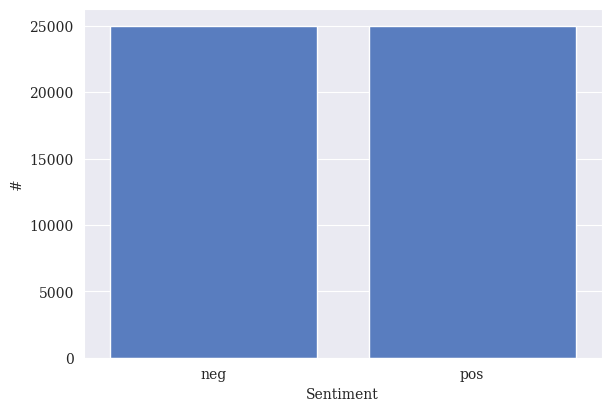

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(6,4), constrained_layout=True)
sns.countplot(data=df, x=TARGET, ax=ax, color="b")
ax.set_xlabel("Sentiment")
ax.set_ylabel("#");

Clean reviews before analyzing tokens

In [6]:
TOKENS = "tokens"
LENGTH = "Text Length"

def clean(df: pd.DataFrame):
    stop_words = nltk.corpus.stopwords.words('english')
    lemmatizer = WordNetLemmatizer()
    df = df.copy()
    df.reset_index(drop=True, inplace=True)
    # Save original text
    df[ORIGINAL_TEXT] = df[TEXT]
    # Convert to lower
    df[TEXT] = df[TEXT].str.lower()
    # Remove URLs
    df[TEXT] = df[TEXT].str.replace(r"http\S+|www.\S+", "", regex=True)
    # Remove HTML
    df[TEXT] = df[TEXT].str.replace("<[^<]+?>", " ", regex=True)
    # Remove symbols
    df[TEXT] = df[TEXT].str.replace(r"[/(){}\[\]\|@,;\-]", " ", regex=True)
    # Remove punctuation
    df[TEXT] = df[TEXT].str.replace(r"[^\w\s]", "", regex=True)
    # Tokenize
    df[TOKENS] = df[TEXT].apply(lambda x: word_tokenize(x))
    # Remove stopwords
    df[TOKENS] = df[TOKENS].apply(lambda x: [word for word in x if word not in stop_words])
    # Lemmatize
    df[TOKENS] = df[TOKENS].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
    # Length of cleaned text
    df[LENGTH] = df[TOKENS].apply(lambda x: len(x))
    # Join and return
    df[TEXT] = df[TOKENS].apply(lambda x: " ".join(x))
    return df


In [7]:
df = clean(df)
df.head()

,review,sentiment,Split,Original Text,tokens,Text Length
0,director make great film poltergeist texas cha...,neg,train,how can a director that makes such great films...,"[director, make, great, film, poltergeist, tex...",23
1,one worst film adaptation musical ever made st...,neg,train,This is one of the worst film adaptations of a...,"[one, worst, film, adaptation, musical, ever, ...",72
2,art film either made 1969 1972 national film p...,neg,train,This is an art film that was either made in 19...,"[art, film, either, made, 1969, 1972, national...",89
3,two funniest comedian movie awful fast forward...,neg,train,"For two of the funniest comedians, the movie w...","[two, funniest, comedian, movie, awful, fast, ...",69
4,doris day never let bad script get even trying...,neg,train,Doris Day never lets a bad script get her down...,"[doris, day, never, let, bad, script, get, eve...",94


Tokenize (using NLTK) and calculate text length

Note: Length depends on tokenizer, it will be different for bert tokenizer

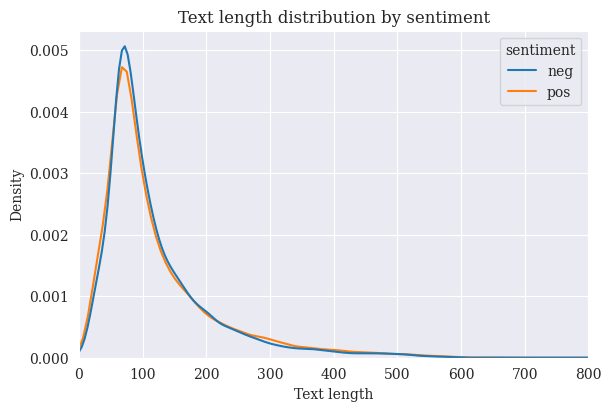

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(6,4), constrained_layout=True)
sns.kdeplot(data=df, x=LENGTH, hue=TARGET, ax=ax)
ax.set_xlabel("Text length")
ax.set_ylabel("Density")
ax.set_title(f"Text length distribution by {TARGET}")
ax.set_xlim(0, 800)
plt.show();

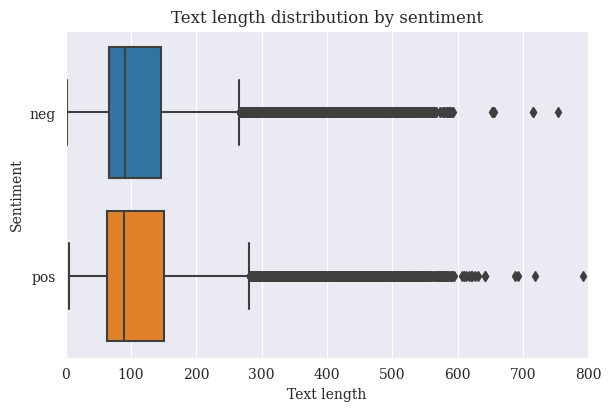

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(6,4), constrained_layout=True)
sns.boxplot(data=df, x=LENGTH, y=TARGET, ax=ax)
ax.set_xlabel("Text length")
ax.set_ylabel("Sentiment")
ax.set_title(f"Text length distribution by {TARGET}")
ax.set_xlim(0, 800)
plt.show();

We see that both positive and negative sentiments have the same distribution for text-length, which is right-skewed, with mean at around 130 and mode at 70

N-Gram Analysis

In [14]:
# Utility function to generate n-grams
def topK_ngrams(corpus: pd.Series, n: int, K: int):
    vectorizer = CountVectorizer(ngram_range=(n, n), analyzer="word")
    sparse_matrix = vectorizer.fit_transform(corpus)
    frequencies = sum(sparse_matrix).toarray()[0]
    frequencies = sorted(
        zip(frequencies, vectorizer.get_feature_names_out()),
        key=lambda x: x[0],
        reverse=True
    )
    frequencies = frequencies[:K]
    counts, ngrams = map(list, zip(*frequencies))
    return ngrams, counts


In [18]:
corpus = df[TEXT]
fig, ax = plt.subplots(1, 3, figsize=(16, 6), constrained_layout=True)
ngrams, counts = topK_ngrams(corpus, 1, 20)
sns.barplot(x=counts, y=ngrams, color="b", ax=ax[0])
ngrams, counts = topK_ngrams(corpus, 2, 20)
sns.barplot(x=counts, y=ngrams, color="b", ax=ax[1])
ngrams, counts = topK_ngrams(corpus, 3, 20)
sns.barplot(x=counts, y=ngrams, color="b", ax=ax[2])
ax[0].set_xlabel("Counts")
ax[1].set_xlabel("Counts")
ax[2].set_xlabel("Counts")
ax[0].set_title("1-gram")
ax[1].set_title("2-grams")
ax[2].set_title("3-grams")
fig.suptitle("n-grams - Whole Corpus")
plt.show();

In [ ]:
corpus = df[df[TARGET].isin(["pos"])][TEXT][:20]
fig, ax = plt.subplots(2, 3, figsize=(16, 6), constrained_layout=True)
ngrams, counts = topK_ngrams(corpus, 1, 20)
sns.barplot(x=counts, y=ngrams, color="b", ax=ax[0, 0])
ngrams, counts = topK_ngrams(corpus, 2, 20)
sns.barplot(x=counts, y=ngrams, color="b", ax=ax[0, 1])
ngrams, counts = topK_ngrams(corpus, 3, 20)
sns.barplot(x=counts, y=ngrams, color="b", ax=ax[0, 2])
ax[0, 0].set_xlabel("Counts")
ax[0, 1].set_xlabel("Counts")
ax[0, 2].set_xlabel("Counts")
ax[0, 0].set_title("1-gram")
ax[0, 1].set_title("2-grams")
ax[0, 2].set_title("3-grams")
fig.suptitle("n-grams for Production Process Controls")
plt.show();

In [ ]:
corpus = df[df[TARGET].isin(["pos"])][TEXT]
fig, ax = plt.subplots(1, 3, figsize=(16, 6), constrained_layout=True)
ngrams, counts = topK_ngrams(corpus, 1, 20)
sns.barplot(x=counts, y=ngrams, color="b", ax=ax[0])
ngrams, counts = topK_ngrams(corpus, 2, 20)
sns.barplot(x=counts, y=ngrams, color="b", ax=ax[1])
ngrams, counts = topK_ngrams(corpus, 3, 20)
sns.barplot(x=counts, y=ngrams, color="b", ax=ax[2])
ax[0].set_xlabel("Counts")
ax[1].set_xlabel("Counts")
ax[2].set_xlabel("Counts")
ax[0].set_title("1-gram")
ax[1].set_title("2-grams")
ax[2].set_title("3-grams")
fig.suptitle("n-grams for Production Process Controls")
plt.show();